### Multipoint Calibration

TODO



#### Initialization

To start, we initialize our system:

In [1]:
# Header. This is hidden from sphinx with the json metadata:
#   {"nbsphinx":"hidden"}

# ipython configuration (reloads source code automatically and plots inline)
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os, sys
import numpy as np

import warnings
warnings.filterwarnings("ignore")

import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rc('image', cmap='Blues')

# Add slmsuite to the python path (For the case where it isn't installed via pip).
# slmsuite-examples is assumed to be installed in the same directory as slmsuite.
sys.path.append(os.path.join(os.getcwd(), '../../slmsuite'))

from slmsuite.hardware.slms.santec import Santec
from slmsuite.hardware.cameras.alliedvision import AlliedVision
from slmsuite.hardware.cameraslms import FourierSLM

from slmsuite.holography.toolbox.phase import blaze, zernike_sum

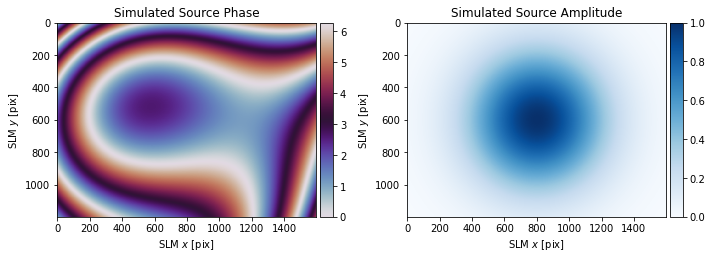

In [62]:
# **README**                        (This cell is hidden from readthedocs rendering)
# If you're reading this, you might have gotten an error from loading physical
# hardware in the next cell, but that doesn't mean you can't run this notebook!
# This cell loads virtual hardware. You can proceed to the next cell.
from slmsuite.hardware.slms.simulated import SimulatedSLM
from slmsuite.hardware.cameras.simulated import SimulatedCamera

# Make the SLM and camera.
slm = SimulatedSLM((1600, 1200), pitch_um=(8,8))
phase_abberation = zernike_sum(
    slm,
    indices=(3, 4, 5, 7, 8),
    weights=(1, -2, 3, 1, 1),
    aperture=None,
    use_mask=False
)
slm.set_source_analytic(                        # Program the virtual source.
    phase_offset=phase_abberation,
    sim=True
)
slm.plot_source(sim=True)
slm.set_source_analytic()                       # Don't bother with wavefront calibration, instead just set it to the same source.

cam = SimulatedCamera(slm, (1440, 1100), pitch_um=(4,4), gain=50)

# Tie the camera and SLM together with an analytic Fourier calibration.
fs = FourierSLM(cam, slm)
M, b = fs.fourier_calibration_build(
    f_eff=80000.,                               # f_eff of 80000 wavelengths or 80 mm with the default 1 um wavelength
    theta=5 * np.pi / 180,                      # Slight rotation for fun.
)
fs.fourier_calibrate_analytic(M, b)

In [2]:
slm = Santec(slm_number=1, display_number=2, wav_um=.633, settle_time_s=.5); print()
cam = AlliedVision(serial="02C5V", fliplr=True)
fs = FourierSLM(cam, slm)

RuntimeError: Santec DLLs not installed. Install these to use Santec SLMs.  Dynamically linked libraries from Santec (usually provided via USB) must be present in the runtime directory:
  - SLMFunc.dll
  - FTD3XX.dll
  Check that these files are present and are error-free.

100%|██████████| 10/10 [00:06<00:00,  1.46it/s]


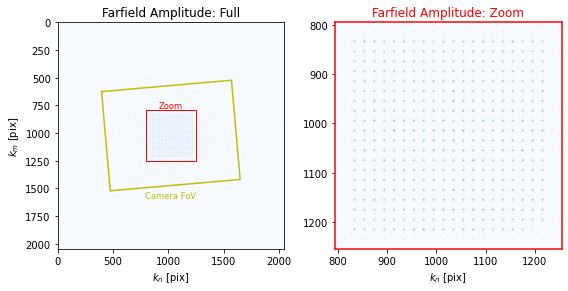

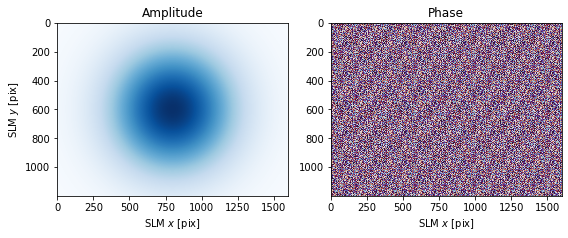

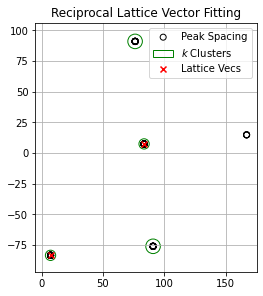

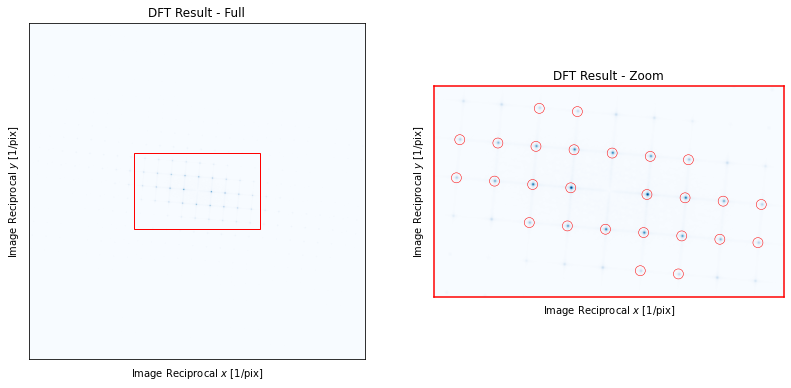

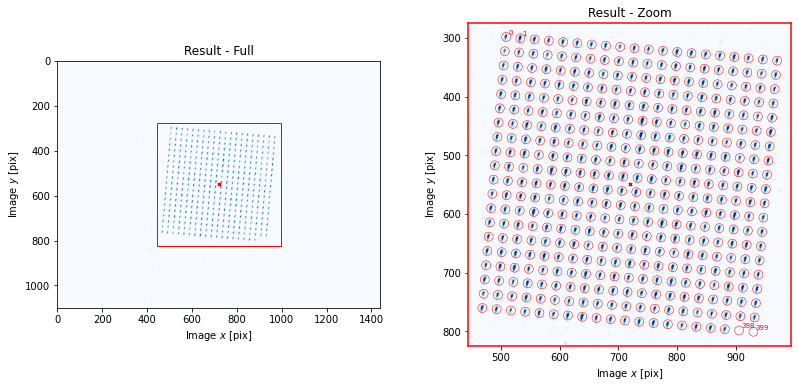

{'M': array([[19923.84488186, -1743.16406713],
        [ 1743.51975466, 19924.22540231]]),
 'b': array([[719.64343419],
        [549.622749  ]]),
 'a': array([[0.],
        [0.]]),
 '__version__': '0.1.0',
 '__time__': '2024-07-23 13:55:58.709717',
 '__timestamp__': 1721757358.709717,
 '__meta__': {'camera': 'camera', 'slm': 'SLM'}}

In [63]:
fs.fourier_calibrate(20, 20, plot=True)

#### Multipoint Calibration Grid

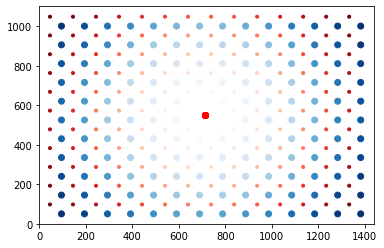

In [10]:
points_ij = fs.wavefront_calibration_points(100, plot=True);

We don't (currently) have a way to simulate varying aberration across a field of
view, so if you're using virtual hardware, all the points will be measuring the same
global aberration.

#### Zernike Wavefront Calibration

In [64]:
from slmsuite.holography.toolbox import convert_vector

points_ij = fs.wavefront_calibration_points(100)

points_zernike = convert_vector(
    points_ij,
    from_units="ij",
    to_units="zernike",
    hardware=fs
)

In [65]:
cam.set_exposure(.05)

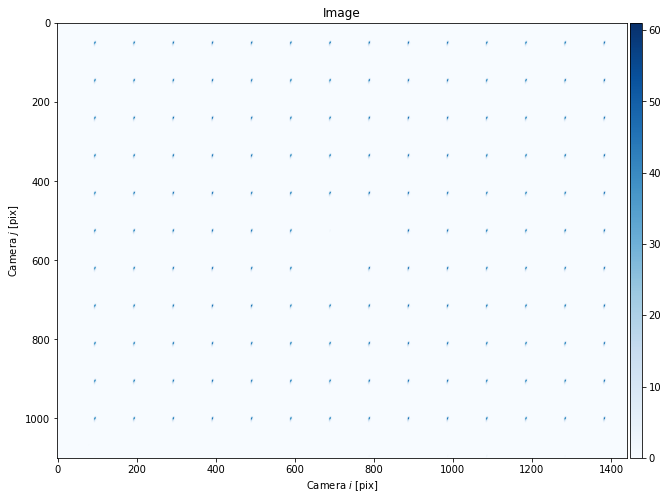

In [66]:
fs.wavefront_calibrate_zernike(points_zernike, zernike_indices=9, perturbation=0, plot=True)

11it [00:10,  1.05it/s]


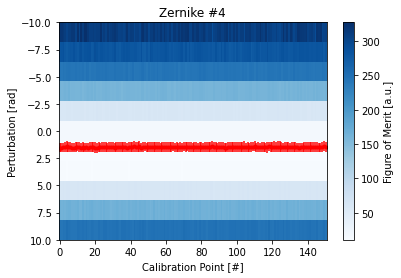

11it [00:10,  1.05it/s]


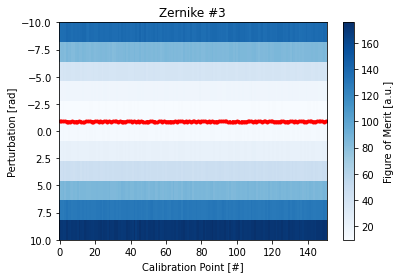

11it [00:10,  1.06it/s]


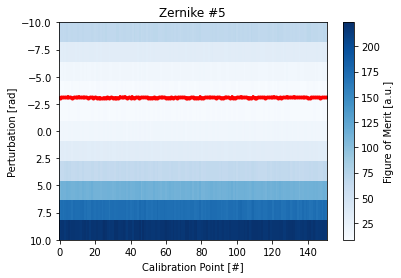

11it [00:10,  1.05it/s]


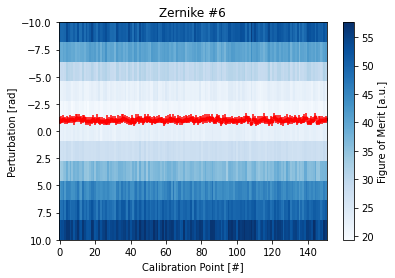

11it [00:10,  1.04it/s]


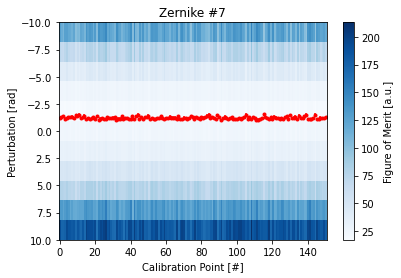

11it [00:10,  1.02it/s]


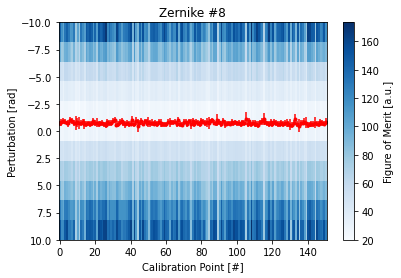

11it [00:10,  1.04it/s]


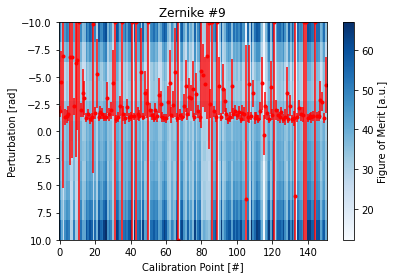

{'zernike_indices': array([2, 1, 4, 3, 5, 6, 7, 8, 9]),
 'corrected_spots': array([[ 1.12345137e+02, -6.13469253e+01, -1.97581619e+02, ...,
         -1.00361298e+03,  1.05461120e+03,  9.29753298e+02],
        [ 9.70773871e+01, -1.75326149e+02, -1.96031378e+01, ...,
         -6.68076573e+02,  5.89827811e+02, -8.37260681e+02],
        [ 1.52243719e+00,  1.52053687e+00,  1.50728990e+00, ...,
          1.46959353e+00,  1.39410246e+00,  1.47008838e+00],
        ...,
        [-1.20678643e+00, -1.29366471e+00, -1.35182018e+00, ...,
         -1.17356314e+00, -1.16257560e+00, -1.26665651e+00],
        [-7.05199981e-01, -8.15189696e-01, -9.46958668e-01, ...,
         -7.48689962e-01, -6.69051792e-01, -8.71312173e-01],
        [-1.82402749e+00, -4.53553979e+00, -6.87570184e+00, ...,
         -2.69516968e+00, -1.21761034e+00, -4.24700109e+00]]),
 'calibration_points_ij': array([[ 788.25,  689.25,  590.25,  788.25,  590.25,  689.25,  590.25,
          887.25,  788.25,  887.25,  590.25,  887.25,  68

In [67]:
fs.wavefront_calibrate_zernike(points_zernike, zernike_indices=9, perturbation=10, plot=True)

11it [00:10,  1.08it/s]


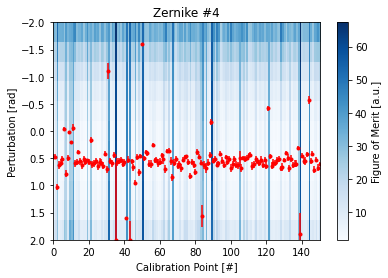

11it [00:10,  1.09it/s]


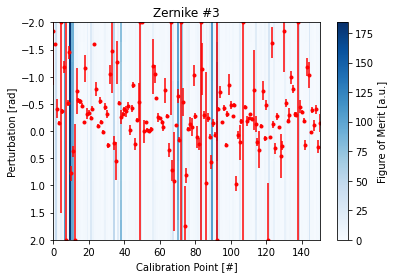

11it [00:10,  1.09it/s]


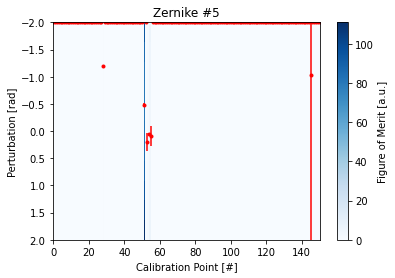

11it [00:10,  1.08it/s]


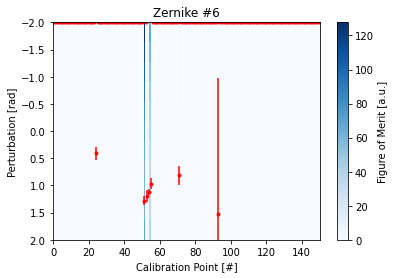

11it [00:10,  1.09it/s]


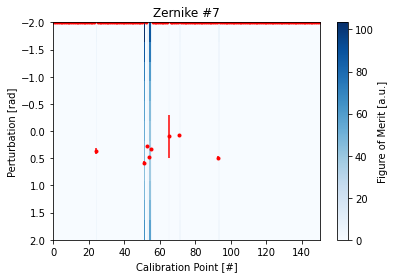

11it [00:10,  1.06it/s]


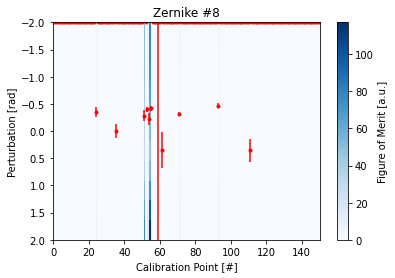

11it [00:10,  1.08it/s]


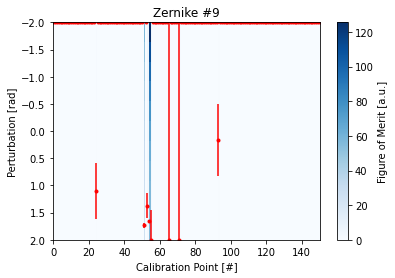

{'zernike_indices': array([2, 1, 4, 3, 5, 6, 7, 8, 9]),
 'corrected_spots': array([[  112.3451374 ,   -61.34692528,  -197.58161875, ...,
         -1003.61298348,  1054.6111956 ,   929.75329818],
        [   97.07738706,  -175.32614924,   -19.60313784, ...,
          -668.07657318,   589.827811  ,  -837.26068132],
        [    1.9920025 ,     1.9918333 ,     2.54155389, ...,
             1.99338271,     2.06442578,     2.08212374],
        ...,
        [   -3.20678643,    -3.29366471,    -3.35182018, ...,
            -3.17356314,    -3.1625756 ,    -3.26665651],
        [   -2.70519998,    -2.8151897 ,    -2.94695867, ...,
            -2.74868996,    -2.66905179,    -2.87131217],
        [   -3.82402749,    -6.53553979,    -8.87570184, ...,
            -4.69516968,    -3.21761034,    -6.24700109]]),
 'calibration_points_ij': array([[ 788.25,  689.25,  590.25,  788.25,  590.25,  689.25,  590.25,
          887.25,  788.25,  887.25,  590.25,  887.25,  689.25,  491.25,
          788.25,  49

In [68]:
fs.wavefront_calibrate_zernike(None, zernike_indices=9, perturbation=2, plot=True)

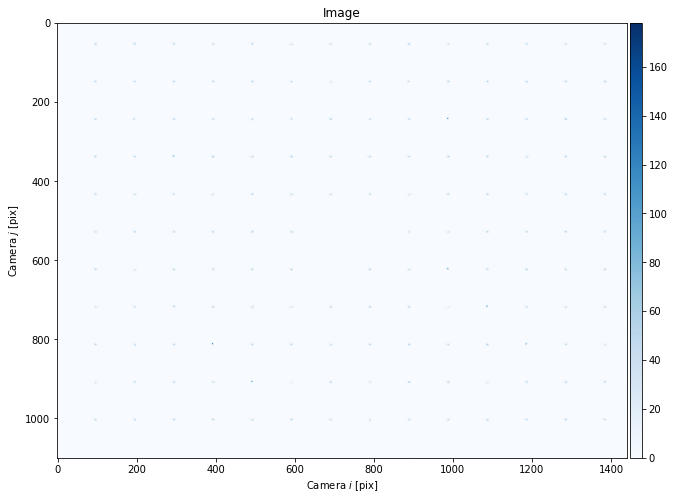

In [69]:
fs.wavefront_calibrate_zernike(None, zernike_indices=9, perturbation=0, plot=True)

#### Multipoint Superpixel Wavefront Calibration

TODO

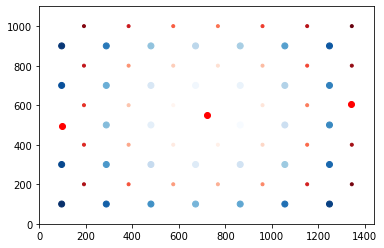

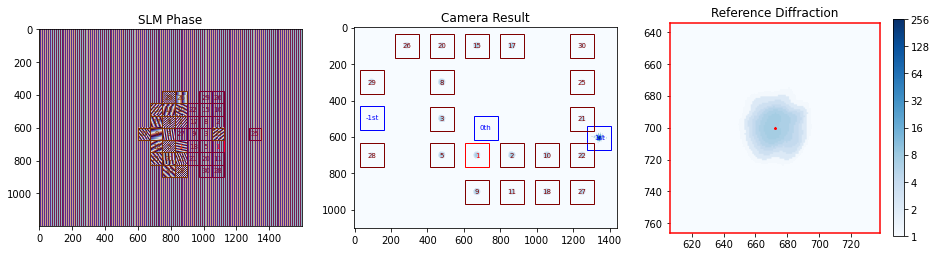

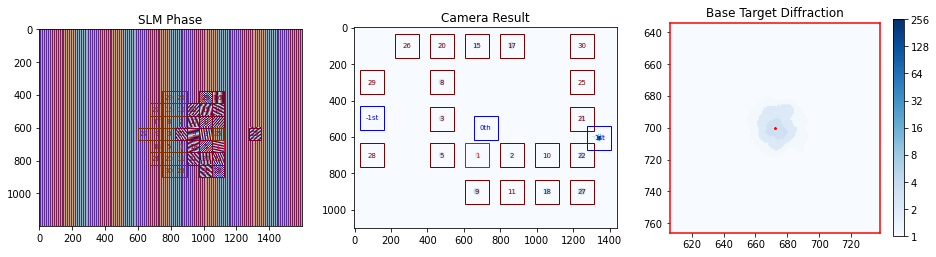

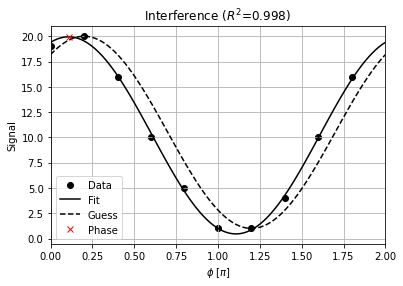

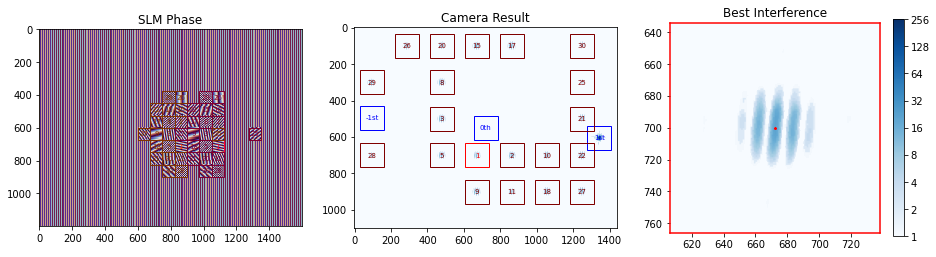

In [ ]:
cam.set_exposure(.1)
movie = fs.wavefront_calibrate_superpixel(
    calibration_points=None,
    field_point=(.25, 0),
    field_point_units="freq",
    superpixel_size=75,
    test_index=2,                       # Testing mode
    phase_steps=10,
    plot=3                              # Special mode to generate a phase .gif
)

from slmsuite.holography.analysis.files import write_image

write_image("wavefront.gif", movie)

We use markdown to display the .gif we just made:

![Phase Movie](wavefront.gif?arg)